In [1]:
# =============================================================================
# Import required modules and functions.
# -----------------------------------------------------------------------------
# Graph utilities: define the graph topology (vertices and edges).
from graph import define_graph_full

# Data and PDE functions: coefficients, potentials, initial and boundary conditions.
from data_ex1 import compute_exact_solution    # Exact solution for validation.
from data_ex1 import a_coefficient               # Coefficient function a(x).
from data_ex1 import b_coefficient               # Coefficient function b(x).
from data_ex1 import p_potential                 # Potential function p(x).
from data_ex1 import f_edge                      # Source term or edge function f.
from data_ex1 import initial_condition_dirichlet_full  # Initial condition for Dirichlet BC.
from data_ex1 import g_boundary_condition_ex1         # Dirichlet boundary condition function g.

# PDE solvers: each function implements a different numerical scheme.
from solver import solve_pde_dirichlet_CN    # Crank-Nicolson method.
from solver import solve_pde_dirichlet_IE    # Implicit Euler method.
from solver import solve_pde_dirichlet_EE    # Explicit Euler method (not used here).
from solver import solve_pde_dirichlet_theta # Theta method (generalized time-stepping).
from solver import solve_pde_dirichlet_SIEM  # SIEM method.
from solver import solve_pde_dirichlet_EXPE  # Exponential time integration method.

import numpy as np
import matplotlib.pyplot as plt
import time

# Example 1.

### Accuracy for methods sable with nx=100 and nt=500

In [2]:
# =============================================================================
# Main function: Sets up the graph-based PDE problem, applies different solvers,
# and compares their accuracy against the exact solution.
# -----------------------------------------------------------------------------
def main():
    """
    Sets up the PDE problem on a graph, solves it using various numerical schemes,
    and computes error estimates by comparing with the exact solution.

    Process:
    1. Define the graph structure via edge connectivity.
    2. Set spatial (nx) and temporal (T, nt) discretization parameters.
    3. Load PDE coefficients, potentials, and initial/boundary conditions.
    4. Solve the PDE using different solvers and time the computations.
    5. Compute the exact solution at discrete time steps.
    6. Evaluate the error (max norm) of each numerical solution.
    7. Print the results in a formatted comparison table.

    Inputs:
        - None (configuration and data are imported from external modules)

    Outputs:
        - Console output: graph details, computation times, and error metrics.
    """
    
    # -------------------------------
    # Define the graph structure.
    # -------------------------------
    # 'full_edges' maps edge identifiers to tuples of vertex indices.
    full_edges = {'e1': (0, 2), 'e2': (1, 2), 'e3': (2, 3), 'e4': (3, 4), 'e5': (3, 5),
                  'e6': (4, 6), 'e7': (5, 6), 'e8': (6, 7), 'e9': (7, 8), 'e10': (7, 9)}
    
    # Partition the graph into edges, interior vertices, and boundary vertices.
    edges, interior_vertices, boundary_vertices = define_graph_full(full_edges)
    print("Edges:", edges)
    print("Interior:", interior_vertices)
    print("Boundary:", boundary_vertices)
    
    # Combine all vertices for later use (initial condition computation).
    all_vertices = interior_vertices + boundary_vertices
    
    # -------------------------------
    # Set discretization parameters.
    # -------------------------------
    nx = 100      # Number of spatial discretization points along each edge.
    T = 1.0       # Final time of simulation.
    nt = 500      # Number of time steps.
    
    # -------------------------------
    # Load PDE coefficients and conditions.
    # -------------------------------
    a = a_coefficient              # Coefficient function a(x) in the PDE.
    b = b_coefficient              # Coefficient function b(x) in the PDE.
    p = p_potential                # Potential function p(x).
    f = f_edge                     # Edge source function f.
    # Compute the initial condition on the graph using the full vertex list.
    y0 = initial_condition_dirichlet_full(edges, all_vertices, nx)
    g = g_boundary_condition_ex1   # Dirichlet boundary condition function.
    
    # Aggregate all problem data into a single list for solver input.
    problem_data = [a, b, p, f, y0, g]
    
    # =============================================================================
    # Solve the PDE using various numerical schemes.
    # Each block times the solver, computes the numerical solution, and estimates error.
    # =============================================================================
    
    # --- Implicit Euler (IE) Scheme ---
    start = time.time()  # Start timer for IE solver.
    Y = solve_pde_dirichlet_IE(edges, boundary_vertices, nx, T, nt, problem_data)
    elapsed = time.time() - start  # Compute elapsed time.
    print(f"PDE solved using IE. #dof= {Y.shape[1]}, time= {elapsed:.3f}s")
     
    # Compute the exact solution at each time step for error analysis.
    mesht = np.linspace(0, T, nt)  # Time discretization mesh.
    y_ex = np.array([compute_exact_solution(edges, all_vertices, interior_vertices, boundary_vertices, nx, t=mesht[k])
                     for k in range(nt)])
    
    # Compute maximum relative error (infinity norm) for IE:
    diff = Y - y_ex
    rel_err_IE = np.linalg.norm(diff, axis=1)  # Error at each time step (spatial norm).
    rel_err_IE = np.linalg.norm(rel_err_IE, np.inf)  # Maximum error over time.
    
    # --- Crank-Nicolson (CN) Scheme ---
    start = time.time()  # Start timer for CN solver.
    Y2 = solve_pde_dirichlet_CN(edges, boundary_vertices, nx, T, nt, problem_data)
    elapsed = time.time() - start
    print(f"PDE solved using CN.  #dof= {Y2.shape[1]}, time= {elapsed:.3f}s")
    
    # Compute maximum relative error for CN:
    diff = Y2 - y_ex
    rel_err_CN = np.linalg.norm(diff, axis=1)
    rel_err_CN = np.linalg.norm(rel_err_CN, np.inf)
    
    # --- Theta Method (theta = 3/4) ---
    start = time.time()  # Start timer for theta method.
    Y5 = solve_pde_dirichlet_theta(edges, boundary_vertices, nx, T, nt, problem_data, 3/4)
    elapsed = time.time() - start
    print(f"PDE solved using theta (3/4).  #dof= {Y5.shape[1]}, time= {elapsed:.3f}s")
    
    # Compute maximum relative error for Theta method:
    diff = Y5 - y_ex
    rel_err_theta = np.linalg.norm(diff, axis=1)
    rel_err_theta = np.linalg.norm(rel_err_theta, np.inf)
    
    # --- SIEM Method ---
    start = time.time()  # Start timer for SIEM solver.
    Y6 = solve_pde_dirichlet_SIEM(edges, boundary_vertices, nx, T, nt, problem_data)
    elapsed = time.time() - start
    print(f"PDE solved using SIEM. #dof= {Y6.shape[1]}, time= {elapsed:.3f}s")
    
    # Compute maximum relative error for SIEM:
    diff = Y6 - y_ex
    rel_err_SIEM = np.linalg.norm(diff, axis=1)
    rel_err_SIEM = np.linalg.norm(rel_err_SIEM, np.inf)
    
    # --- Exponential (EXPE) Method ---
    start = time.time()  # Start timer for EXPE solver.
    Y7 = solve_pde_dirichlet_EXPE(edges, boundary_vertices, nx, T, nt, problem_data)
    elapsed = time.time() - start
    print(f"PDE solved using EXPE. #dof= {Y7.shape[1]}, time= {elapsed:.3f}s")
    
    # Compute maximum relative error for EXPE:
    diff = Y7 - y_ex
    rel_err_EXPE = np.linalg.norm(diff, axis=1)
    rel_err_EXPE = np.linalg.norm(rel_err_EXPE, np.inf)
    
    # =============================================================================
    # Present the results: Display the error comparison of all solvers.
    # =============================================================================
    print("\nAccuracy Comparison:")
    print(f"{'Metric':<7} | {'IE':<9} | {'CN':<9} | {'theta(3/4)':<10} | {'SIEM':<9} | {'EXPE':<9}")
    print(f"{'-'*7} | {'-'*9} | {'-'*9} | {'-'*10} | {'-'*9} | {'-'*9}")
    print(f"{'Error':<7} | {rel_err_IE:<9.3e} | {rel_err_CN:<9.3e} | {rel_err_theta:<10.3e} | {rel_err_SIEM:<9.3e} | {rel_err_EXPE:<9.3e}")

# -----------------------------------------------------------------------------
# Run the main function if this script is executed as the main module.
# -----------------------------------------------------------------------------
if __name__ == "__main__":
    main()


Edges: [(0, 2), (1, 2), (2, 3), (3, 4), (3, 5), (4, 6), (5, 6), (6, 7), (7, 8), (7, 9)]
Interior: [2, 3, 4, 5, 6, 7]
Boundary: [0, 1, 8, 9]
PDE solved using IE. #dof= 1010, time= 63.686s
PDE solved using CN.  #dof= 1010, time= 87.145s
PDE solved using theta (3/4).  #dof= 1010, time= 71.515s
PDE solved using SIEM. #dof= 1010, time= 66.733s
Exponential Euler: dt = 2.000e-03 exceeds accuracy limit; recommend dt = 1.748e-05.
PDE solved using EXPE. #dof= 1010, time= 375.059s

Accuracy Comparison:
Metric  | IE        | CN        | theta(3/4) | SIEM      | EXPE     
------- | --------- | --------- | ---------- | --------- | ---------
Error   | 3.764e-01 | 7.327e-02 | 3.747e-01  | 3.689e-01 | 3.137e+00


### Acurracy for explicit methods such that CFL condition is satisfied.

In [3]:
def main_small_dt():
    """
    Set up and solve the PDE on a graph with a small time step (ensuring CFL condition) using the 
    Explicit Euler (EE) and Theta (with theta=1/4) methods, then compare their errors.

    Process:
    1. Define the graph structure via edge connectivity.
    2. Set spatial (nx) and temporal (T, nt) discretization parameters, with a finer time grid.
    3. Load PDE coefficients, initial condition, and boundary condition.
    4. Solve the PDE using the Explicit Euler (EE) method and compute its execution time.
    5. Compute the exact solution at each time step to evaluate errors.
    6. Solve the PDE using the Theta method with theta=1/4 and compute its error.
    7. Print a formatted table comparing the maximum errors from both methods.

    Inputs:
        - None (all parameters and functions are imported from external modules)

    Outputs:
        - Console output: graph details, execution times, and error metrics for the solvers.
    """
    
    # -------------------------------
    # Define the graph structure.
    # -------------------------------
    # 'full_edges' maps edge identifiers to tuples representing vertex connectivity.
    full_edges = {'e1': (0, 2), 'e2': (1, 2), 'e3': (2, 3), 'e4': (3, 4), 'e5': (3, 5),
                  'e6': (4, 6), 'e7': (5, 6), 'e8': (6, 7), 'e9': (7, 8), 'e10': (7, 9)}
    
    # Obtain the list of edges and the partition of vertices into interior and boundary.
    edges, interior_vertices, boundary_vertices = define_graph_full(full_edges)
    print("Edges:", edges)
    print("Interior:", interior_vertices)
    print("Boundary:", boundary_vertices)
    
    # Combine interior and boundary vertices for the initial condition computation.
    all_vertices = interior_vertices + boundary_vertices
    
    # -------------------------------
    # Set discretization parameters.
    # -------------------------------
    nx = 50      # Number of spatial discretization points along each edge.
    T = 1.0      # Final simulation time.
    nt = 7500    # Number of time steps (small dt, i.e., a fine temporal grid).
    
    # -------------------------------
    # Load PDE coefficients and conditions.
    # -------------------------------
    a = a_coefficient              # Coefficient function a(x) in the PDE.
    b = b_coefficient              # Coefficient function b(x) in the PDE.
    p = p_potential                # Potential function p(x).
    f = f_edge                     # Edge source function f.
    # Compute the initial condition for Dirichlet BCs using the graph's vertices.
    y0 = initial_condition_dirichlet_full(edges, all_vertices, nx)
    g = g_boundary_condition_ex1   # Dirichlet boundary condition function.
    
    # Bundle all problem data for the PDE solvers.
    problem_data = [a, b, p, f, y0, g]
    
    # =============================================================================
    # Solve the PDE using the Explicit Euler (EE) method.
    # =============================================================================
    start = time.time()  # Start timer for EE solver.
    Y3 = solve_pde_dirichlet_EE(edges, boundary_vertices, nx, T, nt, problem_data)
    elapsed = time.time() - start  # Compute elapsed time.
    print(f"PDE solved using EE.  #dof= {Y3.shape[1]}, time= {elapsed:.3f}s")
    
    # Create a time mesh and compute the exact solution at each time step.
    mesht = np.linspace(0, T, nt)
    y_ex = np.array([compute_exact_solution(edges, all_vertices, interior_vertices, boundary_vertices, nx, t=mesht[k])
                     for k in range(nt)])
    
    # Compute the maximum (infinity norm) error for EE:
    diff = Y3 - y_ex
    rel_err_EE = np.linalg.norm(diff, axis=1)  # Spatial error at each time step.
    rel_err_EE = np.linalg.norm(rel_err_EE, np.inf)  # Maximum error over all time steps.
    
    # =============================================================================
    # Solve the PDE using the Theta method with theta=1/4.
    # =============================================================================
    start = time.time()  # Start timer for Theta method.
    Y4 = solve_pde_dirichlet_theta(edges, boundary_vertices, nx, T, nt, problem_data, 1/4)
    elapsed = time.time() - start
    print(f"PDE solved using theta (1/4).  #dof= {Y4.shape[1]}, time= {elapsed:.3f}s")
    
    # Compute the maximum error for the Theta method:
    diff = Y4 - y_ex
    rel_err_theta = np.linalg.norm(diff, axis=1)
    rel_err_theta = np.linalg.norm(rel_err_theta, np.inf)
    
    # =============================================================================
    # Present the results: Display the error comparison between the two methods.
    # =============================================================================
    print("\nAccuracy Comparison:")
    print(f"{'Metric':<7} | {'EE':<9} | {'theta (1/4)':<9}")
    print(f"{'-'*7} | {'-'*9} | {'-'*9}")
    print(f"{'Error':<7} | {rel_err_EE:<9.3e} | {rel_err_theta:<9.3e}")


# -----------------------------------------------------------------------------
# Run the main_small_dt function if this script is executed as the main module.
# -----------------------------------------------------------------------------
if __name__ == "__main__":
    main_small_dt()


Edges: [(0, 2), (1, 2), (2, 3), (3, 4), (3, 5), (4, 6), (5, 6), (6, 7), (7, 8), (7, 9)]
Interior: [2, 3, 4, 5, 6, 7]
Boundary: [0, 1, 8, 9]
CFL condition satisfied. Maximum possible dt = 1.333e-04.
PDE solved using EE.  #dof= 510, time= 256.641s
PDE solved using theta (1/4).  #dof= 510, time= 275.736s

Accuracy Comparison:
Metric  | EE        | theta (1/4)
------- | --------- | ---------
Error   | 5.070e-02 | 5.067e-02


## Usage of memory

In [4]:
from memory_profiler import memory_usage

def main_memory_track_full(method, nx, nt):
    """
    Set up and solve the PDE on a graph using a specified numerical method, while tracking 
    the execution time. The memory profiling is handled externally by the memory_usage function.

    Parameters:
    -----------
    method : str
        The numerical method to be used for solving the PDE. Valid options include:
          - 'IE'        : Implicit Euler method.
          - 'CN'        : Crank-Nicolson method.
          - 'EE'        : Explicit Euler method.
          - 'theta1/4'  : Theta method with theta = 1/4.
          - 'theta3/4'  : Theta method with theta = 3/4.
          - 'SIEM'      : SIEM method.
          - 'EXPE'      : Exponential time integration method.
          
    nx : int
        Number of spatial discretization points along each edge.

    nt : int
        Number of time steps for the simulation.

    Returns:
    --------
    elapsed : float
        The elapsed CPU time (in seconds) required to solve the PDE with the specified method.
    """

    # -------------------------------
    # Define the graph structure.
    # -------------------------------
    # 'full_edges' maps edge identifiers to tuples of connected vertex indices.
    full_edges = {'e1': (0, 2), 'e2': (1, 2), 'e3': (2, 3), 'e4': (3, 4), 'e5': (3, 5),
                  'e6': (4, 6), 'e7': (5, 6), 'e8': (6, 7), 'e9': (7, 8), 'e10': (7, 9)}
    
    # Retrieve edges, interior vertices, and boundary vertices from the graph definition.
    edges, interior_vertices, boundary_vertices = define_graph_full(full_edges)
    # Combine interior and boundary vertices for computing the initial condition.
    all_vertices = interior_vertices + boundary_vertices

    # -------------------------------
    # Set simulation time and load PDE data.
    # -------------------------------
    T = 1  # Final simulation time.
    
    # Load PDE coefficients, potential, source term, and conditions.
    a = a_coefficient
    b = b_coefficient
    p = p_potential
    f = f_edge
    # Compute the initial condition over all vertices.
    y0 = initial_condition_dirichlet_full(edges, all_vertices, nx)
    g = g_boundary_condition_ex1
    # Bundle all problem-specific data for the solvers.
    problem_data = [a, b, p, f, y0, g]

    # -------------------------------
    # Select and execute the appropriate PDE solver.
    # -------------------------------
    if method == 'IE':
        start = time.time()  # Start timer for Implicit Euler.
        Y = solve_pde_dirichlet_IE(edges, boundary_vertices, nx, T, nt, problem_data)
        elapsed = time.time() - start
    elif method == 'CN':
        start = time.time()  # Start timer for Crank-Nicolson.
        Y = solve_pde_dirichlet_CN(edges, boundary_vertices, nx, T, nt, problem_data)
        elapsed = time.time() - start
    elif method == 'EE':
        start = time.time()  # Start timer for Explicit Euler.
        Y = solve_pde_dirichlet_EE(edges, boundary_vertices, nx, T, nt, problem_data)
        elapsed = time.time() - start
    elif method == 'theta1/4':
        start = time.time()  # Start timer for Theta method with theta = 1/4.
        Y = solve_pde_dirichlet_theta(edges, boundary_vertices, nx, T, nt, problem_data, 1/4)
        elapsed = time.time() - start
    elif method == 'theta3/4':
        start = time.time()  # Start timer for Theta method with theta = 3/4.
        Y = solve_pde_dirichlet_theta(edges, boundary_vertices, nx, T, nt, problem_data, 3/4)
        elapsed = time.time() - start
    elif method == 'SIEM':
        start = time.time()  # Start timer for SIEM method.
        Y = solve_pde_dirichlet_SIEM(edges, boundary_vertices, nx, T, nt, problem_data)
        elapsed = time.time() - start
    elif method == 'EXPE':
        start = time.time()  # Start timer for the Exponential method.
        Y = solve_pde_dirichlet_EXPE(edges, boundary_vertices, nx, T, nt, problem_data)
        elapsed = time.time() - start
    else:
        print('No existing method.')
        return None

    print(f'{method} computed.')
    # Return the elapsed time for the selected solver.
    return elapsed

    
if __name__ == "__main__":
    # -------------------------------
    # Set parameters for methods with nx = 100 and nt = 500.
    # -------------------------------
    nx = 100
    nt = 500

    # Profile memory usage and elapsed time for each method using memory_usage.
    memIE, elapsed_IE = memory_usage((main_memory_track_full, ('IE', nx, nt)), max_iterations=5, retval=True, interval=0.1, timeout=None)
    memCN, elapsed_CN = memory_usage((main_memory_track_full, ('CN', nx, nt)), max_iterations=5, retval=True, interval=0.1, timeout=None)
    memtheta34, elapsed_theta34 = memory_usage((main_memory_track_full, ('theta3/4', nx, nt)), max_iterations=5, retval=True, interval=0.1, timeout=None)
    memSIEM, elapsed_SIEM = memory_usage((main_memory_track_full, ('SIEM', nx, nt)), max_iterations=5, retval=True, interval=0.1, timeout=None)
    memEXPE, elapsed_EXPE = memory_usage((main_memory_track_full, ('EXPE', nx, nt)), max_iterations=5, retval=True, interval=0.1, timeout=None)
        
    # -------------------------------
    # Set parameters for methods with a finer time grid (nx = 50 and nt = 7500).
    # -------------------------------
    nx = 50
    nt = 7500
    memEE, elapsed_EE = memory_usage((main_memory_track_full, ('EE', nx, nt)), max_iterations=5, retval=True, interval=0.1, timeout=None)
    memtheta14, elapsed_theta14 = memory_usage((main_memory_track_full, ('theta1/4', nx, nt)), max_iterations=5, retval=True, interval=0.1, timeout=None)

# =============================================================================
# Present the performance results.
# -----------------------------------------------------------------------------
# First table: Compare IE, CN, theta (3/4), SIEM, and EXPE using nx = 100 and nt = 500.
print("\nCPU Performance Comparison: ")
print(f"{'Metric':<11} | {'IE':<6} | {'CN':<6} | {'theta (3/4)':<6} | {'SIEM':<6} | {'EXPE':<6}")
print(f"{'-'*11} | {'-'*6} | {'-'*6} | {'-'*6} | {'-'*6} | {'-'*6}")
print(f"{'Time (ms)':<11} | {elapsed_IE:<6.2f} | {elapsed_CN:<6.2f} | {elapsed_theta34:<6.2f} | {elapsed_SIEM:<6.2f} | {elapsed_EXPE:<6.2f}")
print(f"{'Memory (MB)':<11} | {max(memIE):<6.2f} | {max(memCN):<6.2f} | {max(memtheta34):<6.2f} | {max(memSIEM):<6.2f} | {max(memEXPE):<6.2f}")

# Second table: Compare EE and theta (1/4) using nx = 50 and nt = 7500.
print("\nCPU Performance Comparison:")
print(f"{'Metric':<11} | {'EE':<6} | {'theta (1/4)':<6}")
print(f"{'-'*11} | {'-'*6}  | {'-'*6}")
print(f"{'Time (ms)':<11} | {elapsed_EE:<6.2f} | {elapsed_theta14:<6.2f}")
print(f"{'Memory (MB)':<11} | {max(memEE):<6.2f} | {max(memtheta14):<6.2f}")


IE computed.
CN computed.
theta3/4 computed.
SIEM computed.
Exponential Euler: dt = 2.000e-03 exceeds accuracy limit; recommend dt = 1.748e-05.
EXPE computed.
CFL condition satisfied. Maximum possible dt = 1.333e-04.
EE computed.
theta1/4 computed.

CPU Performance Comparison: 
Metric      | IE     | CN     | theta (3/4) | SIEM   | EXPE  
----------- | ------ | ------ | ------ | ------ | ------
Time (ms)   | 57.13  | 74.68  | 59.79  | 56.71  | 369.08
Memory (MB) | 200.14 | 208.00 | 200.36 | 199.93 | 314.02

CPU Performance Comparison:
Metric      | EE     | theta (1/4)
----------- | ------  | ------
Time (ms)   | 259.12 | 276.61
Memory (MB) | 164.39 | 135.30


Computing the solution using Implicit Euler
Solution computed in 54.657 seconds

Plotting the solution per edge...


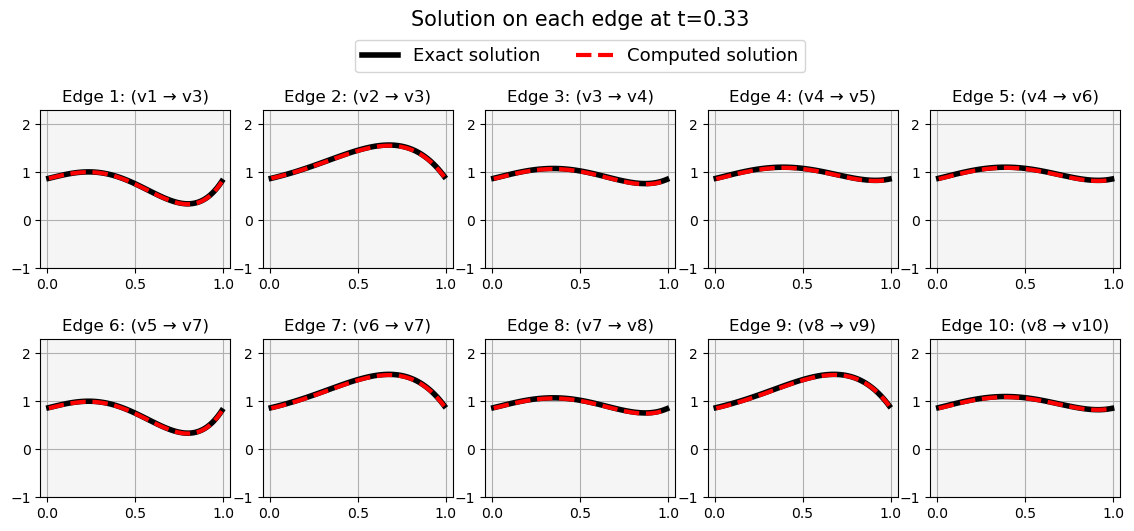


Plotting graph and the solution on it...


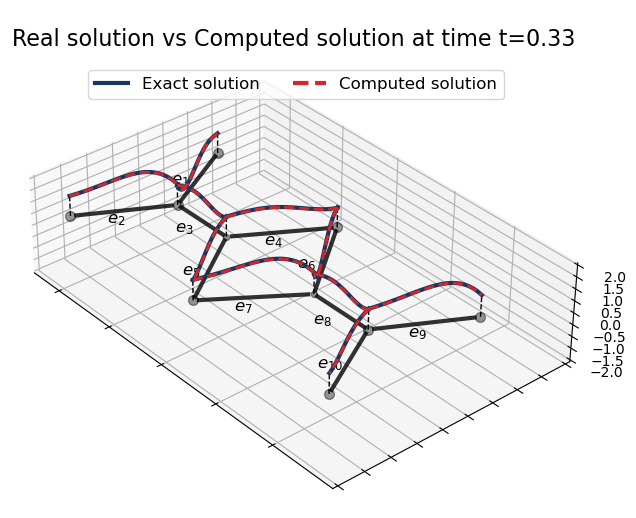

In [6]:
# -----------------------------------------------------------------------------
# Import plotting functions and position definitions for visualization.
# -----------------------------------------------------------------------------
from data_ex1 import define_positions_example_1  # Provides vertex positions for plotting.
from plot_functions import plot_edges            # Function to plot the solution along each edge.
from plot_functions import plot_graph_3d_with_curves  # Function to plot a 3D graph with solution curves.

# =============================================================================
# Problem Setup: Define the graph structure and simulation parameters.
# =============================================================================
# Define a dictionary mapping each edge identifier to a tuple of vertex indices.
full_edges = {'e1': (0, 2), 'e2': (1, 2), 'e3': (2, 3), 'e4': (3, 4), 'e5': (3, 5),
              'e6': (4, 6), 'e7': (5, 6), 'e8': (6, 7), 'e9': (7, 8), 'e10': (7, 9)}

# Generate the graph structure:
#   - edges: List or dictionary of edges.
#   - interior_vertices: Vertices where the PDE is solved.
#   - boundary_vertices: Vertices with prescribed Dirichlet conditions.
edges, interior_vertices, boundary_vertices = define_graph_full(full_edges)

# Set discretization parameters.
nx = 100    # Number of spatial discretization points per edge.
T = 1.0     # Final simulation time.
nt = 500    # Number of time steps.
all_vertices = interior_vertices + boundary_vertices  # Combined list of all vertices.

# -----------------------------------------------------------------------------
# PDE Data and Initial/Boundary Conditions Setup.
# -----------------------------------------------------------------------------
print("Computing the solution using Implicit Euler")

# Load PDE coefficients, potential, and source term.
a = a_coefficient       # Coefficient function a(x) in the PDE.
b = b_coefficient       # Coefficient function b(x) in the PDE.
p = p_potential         # Potential function p(x).
f = f_edge              # Edge source function f(x).

# Compute the initial condition for the graph using all vertex positions.
y0 = initial_condition_dirichlet_full(edges, all_vertices, nx)
# Load the Dirichlet boundary condition function.
g = g_boundary_condition_ex1

# Aggregate all problem-specific data into a single list for the solver.
problem_data = [a, b, p, f, y0, g]

# -----------------------------------------------------------------------------
# Solve the PDE using the Implicit Euler (IE) method.
# -----------------------------------------------------------------------------
# The solver returns:
#   - times: An array of time values at which the solution was computed.
#   - Y: The computed solution array (e.g., with dimensions nt x dof).
#   - all_vertices: The vertices used (may be updated or simply passed through).
start = time.time()
Y = solve_pde_dirichlet_IE(edges, boundary_vertices, nx, T, nt, problem_data)
elapsed = time.time() - start
print(f"Solution computed in {elapsed:0.3f} seconds")

# -----------------------------------------------------------------------------
# Plot the solution along each edge.
# -----------------------------------------------------------------------------
print(f"\nPlotting the solution per edge...")
t_index = int(nt/3) + 1

# plot_edges: Visualizes the solution (Y) on each edge of the graph.
# Inputs:
#   - Y: Solution array.
#   - compute_exact_solution: function exact solution.
#   - nx, nt, T: Spatial and temporal discretization parameters.
#   - t_index: Time index used for plotting the solution curve.
#   - full_edges: The dictionary defining graph connectivity.
#   - show: Whether to display the plot.
#   - save: Whether to save the plot to file.
#   - example: Identifier for the saved file.
plot_edges(Y, compute_exact_solution, nx, nt, T, t_index,
            full_edges, show=True, save=False, example='example_0')

# -----------------------------------------------------------------------------
# Plot the graph along with the solution curves in 3D.
# -----------------------------------------------------------------------------
# Obtain vertex positions from a predefined example.
positions = define_positions_example_1()
# Select a specific time index to visualize the solution curve on the graph.
t_index = int(nt/3) + 1

print(f"\nPlotting graph and the solution on it...")
# plot_graph_3d_with_curves: Generates a 3D visualization of the graph,
# overlaying the solution curves. Inputs include:
#   - Y: The solution array.
#   - compute_exact_solution: function exact solution.
#   - full_edges: Graph connectivity dictionary.
#   - nx, nt, T: Discretization parameters.
#   - t_index: Time index used for plotting the solution curve.
#   - positions: Vertex positions.
#   - show: Whether to display the plot.
#   - elevation, azimuth: Viewing angles for the 3D plot.
#   - zorder: Plot layering order.
#   - save: Whether to save the plot to file.
#   - example: Identifier for the saved file.
plot_graph_3d_with_curves(Y, compute_exact_solution, full_edges, nx, nt, T, t_index, positions, 
                          show=True, elevation=33, azimuth=320, zorder=100, 
                          save=False, example="example_0_3d")
